# [Precomputed Real-Time Texture Synthesis with Markovian Generative Adversarial Networks](https://arxiv.org/abs/1604.04382)
<img src="Notebook%20Images/MGAN.png">

In [1]:
import utils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import functools
from time import time
from tqdm import tqdm
from IPython.core.debugger import set_trace
from pathlib import Path
from IPython import display
import cv2

In [2]:
# utils.pylab.rcParams['figure.figsize'] = (8.0, 10.0)
# utils.pylab.rcParams['figure.dpi'] = 80

In [3]:
style_path ="Images/Style/picasso.jpeg"
style_name = style_path.split("/")[-1].split(".")[0]
model_folder = f"./Models/MGAN/{style_name}/"
MDAN_output_folder = f"./Outputs/MGAN/MDANsData/{style_name}/"
Path(model_folder).mkdir(parents=True, exist_ok=True)
Path(MDAN_output_folder).mkdir(parents=True, exist_ok=True)
img_size = (384, 384)

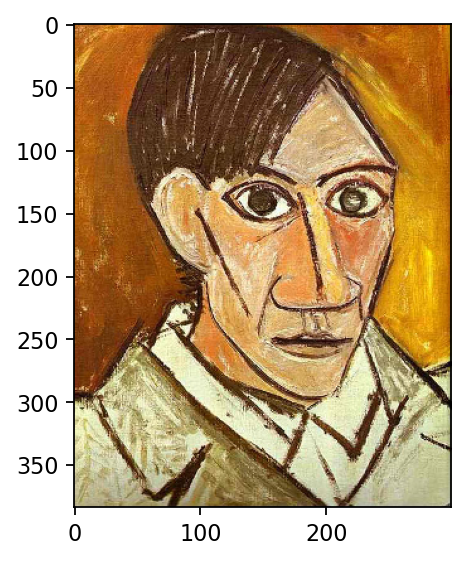

In [4]:
style_img = utils.load_image(style_path)
plt.figure(dpi=160)
# style_img = utils.resize(style_img, img_size)
plt.imshow(style_img/255)

In [7]:
@tf.function
def hinge_loss(y_true, y_pred, margin=1):
  y_true = tf.reshape(y_true, [-1, *[1]*(len(y_pred.shape)-1)])
  return tf.math.maximum(margin-y_pred*y_true, 0)

In [8]:
content_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "Images/small_coco",
  label_mode=None,
  seed=123,
  image_size=img_size)

Found 100 files belonging to 1 classes.


In [8]:
CROP_SIZE = (128, 128, 3)
def aug(img):
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  
  OLD_SHAPE = img.shape
  NEW_SIZE = tf.random.uniform((2,), int(OLD_SHAPE[0]*0.75), int(OLD_SHAPE[0]*1.25) , dtype=tf.int32)
  img = tf.image.resize(img, NEW_SIZE)
  img = tf.image.random_crop(img, CROP_SIZE)
  
  return img

In [12]:
content_dataset = (
  content_ds._input_dataset # before batch
  .map(aug).batch(16)
)

# MDANs

In [13]:
class Discriminator(tf.keras.Model):
  def __init__(
    self,
    conv_channels=[128],
    patchsize=4,
    activation=tf.keras.layers.LeakyReLU(),
    vgg_layer_for_D="block3_conv1",
    vgg_layer_for_content_loss = "block5_conv1",
    vgg16_or_vgg19=19,
    batch_input_shape=(None,None,None,3),
  ):
    
    super(Discriminator, self).__init__()
    self.vgg_layer_for_D = vgg_layer_for_D
    self.vgg_layer_for_content_loss = vgg_layer_for_content_loss
    
    self.activation = activation
    
    self._vgg, _ = utils.VGG(
      depth=vgg16_or_vgg19,
      ret_layers=[vgg_layer_for_D]+[vgg_layer_for_content_loss],
      preprocess=True,
    )
    
    vgg = self._vgg
    vgg.trainable=False
    self.batch_input_shape = batch_input_shape
    
    self.init_discriminator(
      conv_channels, patchsize)
    
    self.build(batch_input_shape)
  
  def init_discriminator(
    self,
    conv_channels,
    patchsize,
  ):
    assert isinstance(conv_channels, list), f"now only support list, got{type(conv_channels)}"
    
    Input = self._vgg.inputs[0]
    enc_result = self._vgg(Input)[0]
    before_activation = enc_result.op.inputs[0]
    
    deep_input = tf.keras.Input(before_activation.shape[1:])
    x = deep_input
    x = self.activation(x)
    x = tf.image.extract_patches(
      images=x,
      sizes=[1, patchsize, patchsize, 1],
      strides=[1, 1, 1, 1],
      rates=[1, 1, 1, 1],
      padding="VALID",
      name=f"patch_gather_{patchsize}x{patchsize}",
    )
    for filters in conv_channels:
      x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=(3,3),
      )(x)
      x = self.activation(x)
      
    x = tf.keras.layers.Conv2D(1, (1, 1),)(x)
    
    output= x
  
    self.discrimator_top = tf.keras.Model(deep_input, output)
    self.discrimator = tf.keras.Model(Input, self.discrimator_top(before_activation))
  
  def get_vgg(self):
    return self._vgg
  
  def get_VGG_with_discrimator(self):
    inputs = self._vgg.inputs
    D_outputs = self.discrimator.outputs
    C_outputs = self._vgg.outputs[1:]# content loss's output
    return tf.keras.Model(inputs, D_outputs+C_outputs)
  
  def call(self, inputs):
    return self.discrimator(inputs)

In [14]:
def MDAN_train_step(SI, X, Y, MDAN,opt, lambda_s=1, lambda_c=1, lambda_tv=1e-5):
  _ , MDAN_X_c = MDAN(X)
  with tf.GradientTape() as input_tape, tf.GradientTape() as dis_tape:
    SI255 = SI*255
    MDAN_SI255_s, MDAN_SI255_c = MDAN(SI255)
    MDAN_Y_s, _ = MDAN(Y)
    
    L_s = lambda_s*tf.reduce_mean(hinge_loss(tf.ones(MDAN_SI255_s.shape[0]),MDAN_SI255_s))
    L_c = lambda_c*tf.reduce_mean((MDAN_X_c-MDAN_SI255_c)**2)
    L_tv = lambda_tv*tf.reduce_mean(tf.image.total_variation(SI255))
    SI_loss =  L_s + L_c + L_tv
    
    dis_loss = lambda_s*(
      tf.reduce_mean(hinge_loss(-1.0*tf.ones(MDAN_SI255_s.shape[0]),MDAN_SI255_s))
    + tf.reduce_mean(hinge_loss(1.0*tf.ones(MDAN_Y_s.shape[0]), MDAN_Y_s)))
  
  gradients_of_SI = input_tape.gradient(SI_loss, SI)
  opt.apply_gradients([(gradients_of_SI, SI)])
  
  gradients_of_dis = dis_tape.gradient(dis_loss, MDAN.trainable_variables)
  opt.apply_gradients(zip(gradients_of_dis, MDAN.trainable_variables))
  
  SI.assign(tf.clip_by_value(SI,0,1))
  
  return SI,{
    "L_s": L_s,
    "L_c": L_c,
    "L_tv": L_tv,
    "SI_loss":SI_loss,
    "dis_loss":dis_loss,
  }

In [55]:
def go_MDANs(SI,X,Y, MDAN, itr_shift=0, epoches=100 ):
  train_step = tf.function(MDAN_train_step)
  opt = opt=tf.keras.optimizers.Adam(0.02,0.5)
  
  for i in tqdm(range(epoches)):
    _, log = train_step(
      SI,X,Y,MDAN,opt,
      lambda_s=1,
      lambda_c=1,
      lambda_tv=1e-4)
    if i % 100 == 0 or i == epoches-1:
      display.clear_output(wait=True)
      print(i,*[(k, v.numpy())for (k,v) in log.items()],sep='\n')
      N = SI.shape[0]
      r = min(4,len(X))
      c = N//r + (N%r > 0)
      plt.figure(dpi=240)
      for plot_itr in range(X.shape[0]):
        plt.subplot(r, c, plot_itr+1)
        plt.title(f"{plot_itr+itr_shift:05d}")
        plt.axis("off")
        plt.imshow(SI[plot_itr])
      plt.show()

In [57]:
style_imgs_cap = 10000

700
('L_s', 3660.19)
('L_c', 5954.8896)
('L_tv', 212.18481)
('SI_loss', 9827.265)
('dis_loss', 13964.394)


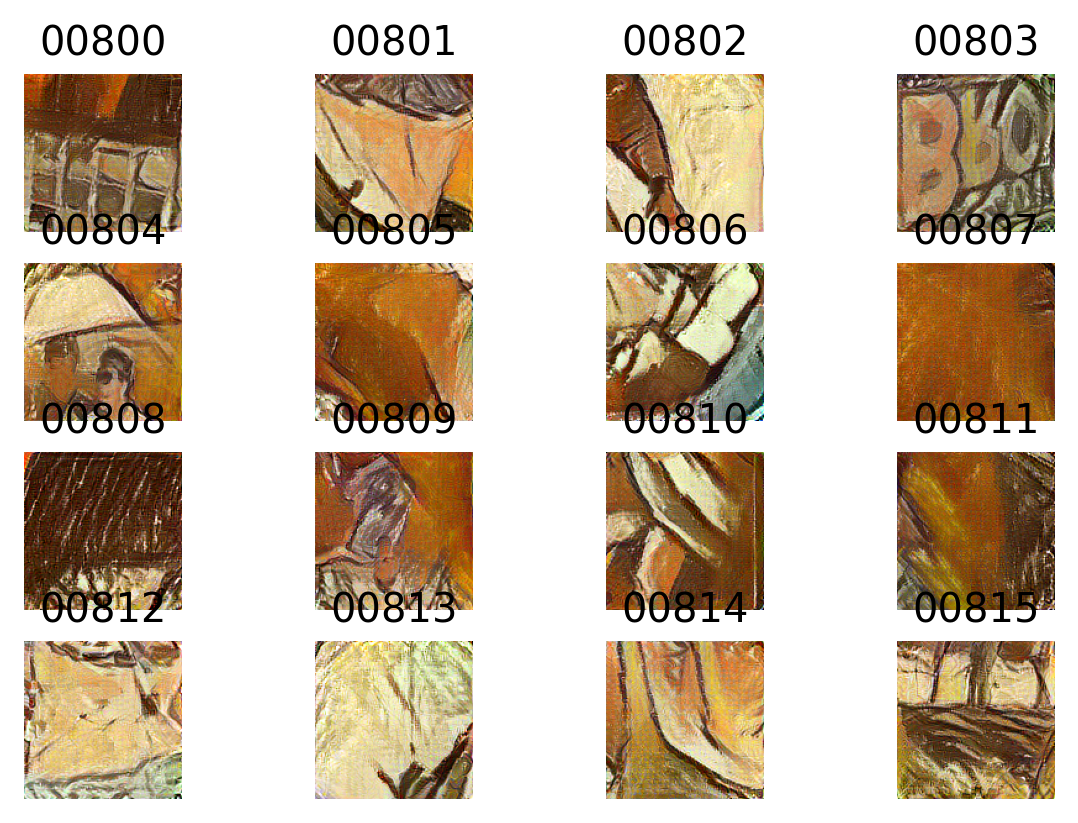

 76%|███████▌  | 760/1000 [01:33<00:27,  8.87it/s]

In [ ]:
current_itr = 0
dis = Discriminator()
MDAN = dis.get_VGG_with_discrimator() 
while current_itr < style_imgs_cap:
  X = tf.constant(next(content_dataset.as_numpy_iterator()))
  SI = tf.Variable(X/255)
  Y = tf.constant(style_img[tf.newaxis])
  
  go_MDANs(SI,X,Y,MDAN, epoches=1000, itr_shift=current_itr)
  
  XSI = tf.concat([X/255,SI],axis=1)
  for _x in XSI.numpy():
    tf.keras.preprocessing.image.save_img(MDAN_output_folder+f"{current_itr:05d}_XSI.jpg",_x)
    current_itr+=1

# Training Generator

In [24]:
def split_XSI(img):
  L = img.shape[0]//2
  return (img[:L,...], img[L:,...])

In [25]:
raw_XSI_dataset = (
  tf.data.Dataset.list_files(MDAN_output_folder+"*.jpg", shuffle=True)
  .map(tf.io.read_file)
  .map(tf.io.decode_image)
)
XSI_dataset = (
  raw_XSI_dataset
  .map(lambda x: tf.py_function(func=split_XSI,
          inp=[x], Tout=(tf.uint8, tf.uint8)))
  .batch(64)
)

Cause: could not parse the source code:

  .map(lambda x: tf.py_function(func=split_XSI,
          inp=[x], Tout=(tf.uint8, tf.uint8)))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

  .map(lambda x: tf.py_function(func=split_XSI,
          inp=[x], Tout=(tf.uint8, tf.uint8)))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
len(raw_XSI_dataset)

10000

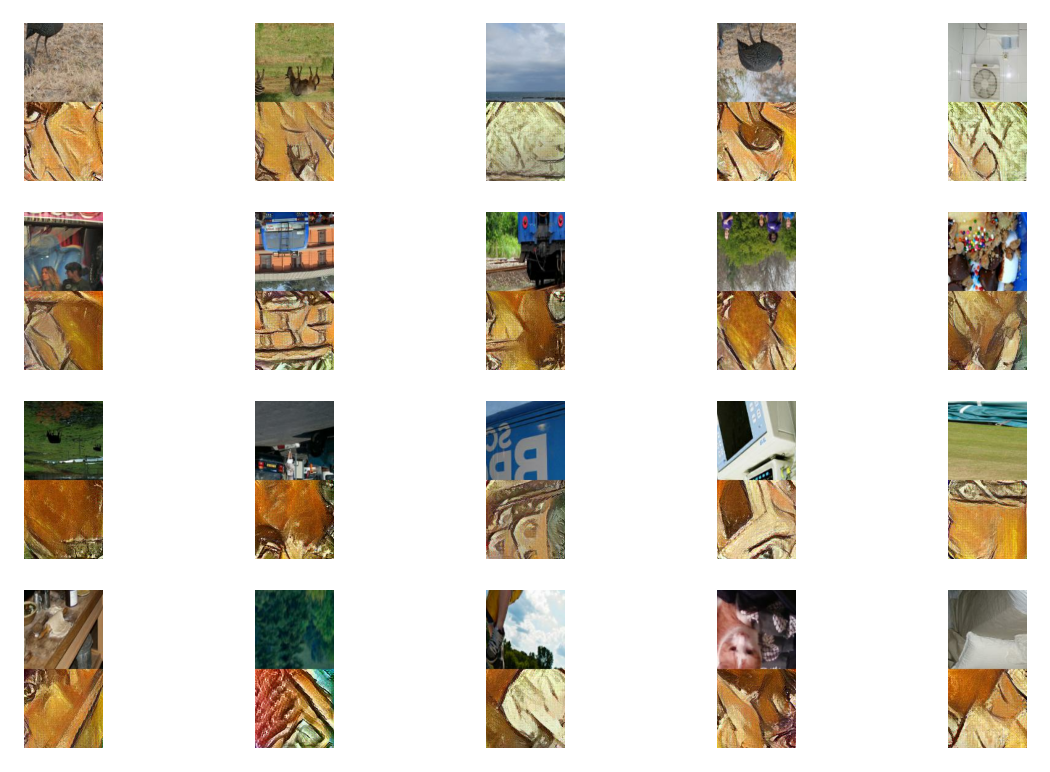

In [27]:
preview = 20
images = list(raw_XSI_dataset.take(preview).as_numpy_iterator())
c = 5
r = preview//c + (preview%c != 0)
plt.figure(dpi=240)
for itr, img in enumerate(images):
  plt.subplot(r,c,itr+1)
  plt.imshow(img)
  plt.axis("off")

In [28]:
class Generator(tf.keras.Model):
  def __init__(
    self,
    VGG_last=(4,1),
    batch_input_shape=(None,None,None,3),
  ):
    super(Generator, self).__init__()
    self.__upsample_times = VGG_last[0]-1
    self._vgg, _ = utils.VGG(ret_layers=[VGG_last])
    self._vgg.trainable = False
    self.init_generator()
    
    self.build(batch_input_shape)
  
  def init_generator(self):
    Input = self._vgg.inputs[0]
    enc_result = self._vgg(Input)
    
    deepInput = x = tf.keras.Input(batch_shape=enc_result.shape)
    x = tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], mode="REFLECT")
    x = tf.keras.layers.Conv2D(2*32*2**self.__upsample_times,(3,3))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.ReLU()(x)
    for _itr in range(self.__upsample_times-1):
      filters_factor = 2**(self.__upsample_times)
      x = tf.keras.layers.UpSampling2D((2,2))(x)
      x = tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], mode="REFLECT")
      x = tf.keras.layers.Conv2D(32*filters_factor,(3,3))(x)
      x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
      x = tf.keras.layers.ReLU()(x)
      
    x = tf.keras.layers.UpSampling2D((2,2))(x)
    x = tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], mode="REFLECT")
    x = tf.keras.layers.Conv2D(3,(3,3))(x)
    x = tf.sigmoid(x)*255
    
    self.generator_top = tf.keras.Model(deepInput, x)
    self.generator = tf.keras.Model(self._vgg.inputs, self.generator_top(enc_result))
  
  def call(self, inputs):
    return self.generator(inputs)

gen = Generator()

In [29]:
def precetual_loss(target, img, model=gen._vgg):
  return tf.reduce_mean((model(target)-model(img))**2)

In [30]:
opt=tf.keras.optimizers.Adam(learning_rate=1e-4)
gen.compile(
  loss=precetual_loss,
  optimizer=opt,
)

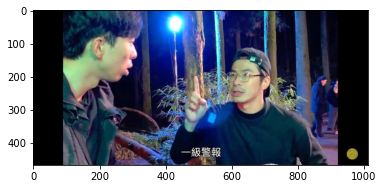

In [31]:
content_test = utils.load_image(
  "Images/Content/Alarm.png"
)
plt.imshow(content_test/255)
plt.show()
class plot_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 1 == 0:
      plt.imshow(self.model(content_test[tf.newaxis])[0]/255)
      plt.show()

In [32]:
MGAN_top_path = model_folder+"MGAN_top_{}.h5"

Epoch 1/3
157/157 [==============================] - ETA: 0s - loss: 712841.1875

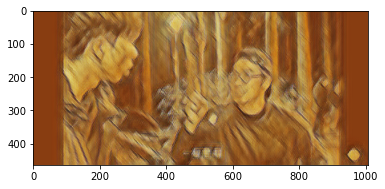

157/157 [==============================] - 61s 389ms/step - loss: 712841.1875
Epoch 2/3
157/157 [==============================] - ETA: 0s - loss: 551953.4375

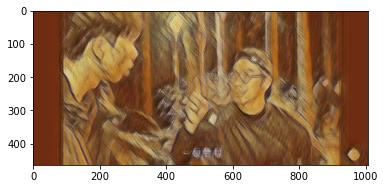

157/157 [==============================] - 60s 380ms/step - loss: 551953.4375
Epoch 3/3
157/157 [==============================] - ETA: 0s - loss: 516739.9375

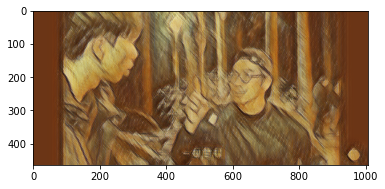

157/157 [==============================] - 60s 381ms/step - loss: 516739.9375


In [33]:
gen.fit(XSI_dataset, epochs=3, callbacks=[plot_callback()])

gen.generator_top.save(MGAN_top_path.format("pretrain_3"))

In [57]:
gen.generator_top.load_weights(MGAN_top_path.format("pretrain"))

In [58]:
# I = images[0]
I = utils.load_image("Images/Content/kid.jpeg")

In [59]:
P = gen(I[tf.newaxis])

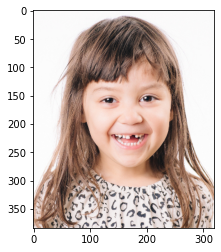

In [60]:
plt.imshow(I/255)

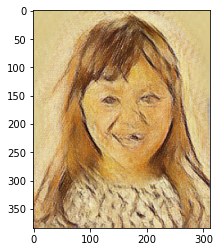

In [61]:
plt.imshow(P[0]/255)

In [62]:
I = images[0]
# I = utils.load_image("Images/Content/kid.jpeg")

In [63]:
P = gen(I[tf.newaxis])

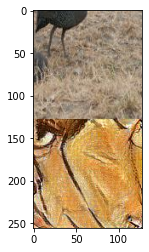

In [64]:
plt.imshow(I/255)

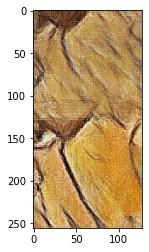

In [65]:
plt.imshow(P[0]/255)

# Go GAN Training

In [66]:
dis = Discriminator()
# dis.discrimator_top.load_weights(MDAN_top_path.format("pretrain"))
MDAN = dis.get_VGG_with_discrimator()

NameError: name 'Discriminator' is not defined

In [ ]:
gen = Generator()
gen.generator_top.load_weights(MGAN_top_path.format("pretrain"))
MGAN = gen.generator

In [ ]:
content_loss = lambda tensor, target: tf.reduce_mean((tensor-target)**2)
style_loss = lambda tensor, target: tf.reduce_mean(hinge_loss(target, tensor))

In [ ]:
opt = tf.keras.optimizers.Adam(0.002, 0.5)

In [198]:
@tf.function
def train_step(X, Y, opt=opt, MDAN=MDAN, MGAN=MGAN, lambda_s=100, lambda_c=1, lambda_tv = 1e-6):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    GX = MGAN(X,training=True)
    concate_GX_Y = tf.concat([GX,Y], axis=0)
    
    MDAN_GX_s, MDAN_GX_c = MDAN(GX, training=True)
    _, MDAN_X_c = MDAN(X)
    
    LG_s = lambda_s*style_loss(MDAN_GX_s, 1.)
    LG_c = lambda_c*content_loss(MDAN_GX_c, MDAN_X_c)
    LG_tv = lambda_tv*tf.reduce_mean(tf.image.total_variation(GX))
    MDAN_GX_Y_s, _ = MDAN(concate_GX_Y, training=True)
    label = tf.concat(
      [-tf.ones(GX.shape[0]), tf.ones(Y.shape[0])], axis=0,
    )
    
    
    dis_loss = lambda_s*style_loss(MDAN_GX_Y_s,label)
    gen_loss = LG_s + LG_c + LG_tv
    
  gradients_of_generator = gen_tape.gradient(gen_loss, MGAN.trainable_variables)
  opt.apply_gradients(zip(gradients_of_generator, MGAN.trainable_variables))
    
  gradients_of_discriminator = disc_tape.gradient(dis_loss, MDAN.trainable_variables)
  opt.apply_gradients(zip(gradients_of_discriminator, MDAN.trainable_variables))
  return GX, {
    "gen_loss" : gen_loss,
    "dis_loss" : dis_loss,
    "LG_s" : LG_s,
    "LG_c" : LG_c,
    "LG_tv" : LG_tv,
  }

In [199]:
content_test = utils.load_image(
  "Images/Content/Alarm.png"
)

1510 {'gen_loss': 540.3114, 'dis_loss': 0.0, 'LG_s': 153.53134, 'LG_c': 386.71896, 'LG_tv': 0.061086927}


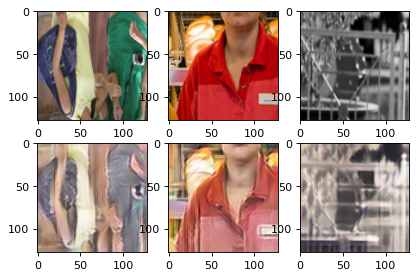

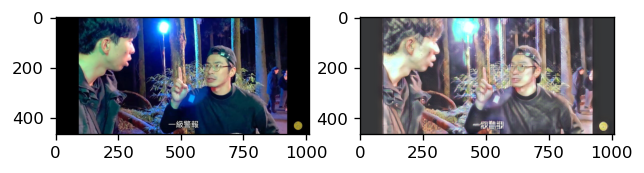

 15%|█▌        | 1516/10000 [12:37<1:10:39,  2.00it/s]


KeyboardInterrupt: 

In [200]:
def go_training(ds_X, ds_Y, save_epochs=500, steps=10000, **kwargs):
  def gen_ds(ds):
    while True:
      for item in ds:
        yield item
        
  gen_ds_X = gen_ds(ds_X)
  gen_ds_Y = gen_ds(ds_Y)
  
  start_time = 0
  for itr in tqdm(range(steps)):
    X = tf.constant(next(gen_ds_X))
    Y = tf.constant(next(gen_ds_Y))
    
    GX, losses = train_step(X, Y, **kwargs)
    if time()-start_time > 10:
      start_time = time()
      display.clear_output(wait=True)
      print(itr, {k: v.numpy() for (k, v) in losses.items()})
      for plot_itr, (x, gx) in enumerate(zip(X,GX)):
        if plot_itr >= 3:
          break
        plt.subplot(2,3,plot_itr+1)
        plt.imshow(x/255)
        plt.subplot(2,3,plot_itr+1+3)
        plt.imshow(gx/255)
      plt.show()
      
      plt.figure(dpi=120)
      plt.subplot(1,2,1)
      plt.imshow(content_test/255)
      plt.subplot(1,2,2)
      plt.imshow(MGAN(content_test[tf.newaxis])[0]/255)
      plt.show()
      
    if (itr % save_epochs) == 0:
      print("save image")
      dis.discrimator_top.save(MDAN_top_path.format(f"{itr:05d}"))
      dis.discrimator_top.save(MDAN_top_path.format(f"last"))
      
      gen.generator_top.save(MGAN_top_path.format(f"{itr:05d}"))
      gen.generator_top.save(MGAN_top_path.format(f"last"))
      
      cv2.imwrite(model_folder+f"/example_{itr:05d}.jpg",MGAN(content_test[tf.newaxis]).numpy()[0].astype(np.uint8))
      
go_training(
  content_dataset._input_dataset.batch(32),
  style_dataset._input_dataset.batch(32),
  lambda_s=1e2,
  lambda_c=1e-1,
  lambda_tv=1e-7,
  steps=10000)